In [1]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    """주어진 텍스트 데이터에 대해 BERT 임베딩을 생성하는 함수"""
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    """아파트 이름에서 브랜드명을 추출하는 함수"""
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

# 아파트 브랜드 리스트 (우선순위 순)
brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]


# ===================================================================
# 3. 데이터 로드
# ===================================================================
print("🚚 데이터를 로드합니다...")
df = pd.read_csv("final_data.csv")
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
print("✅ 데이터 로드 완료")


# ===================================================================
# 4. 특성 공학 (Feature Engineering)
# ===================================================================
print("\n🔬 특성 공학을 적용합니다...")

# '소규모단지여부' 변수 추가
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)

# 날짜 관련 특성 생성
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')

# 브랜드, 건설사, 지역 관련 파생 변수 생성
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']

# 수치형 파생 변수 생성
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")


# ===================================================================
# 5. 텍스트 임베딩 생성
# ===================================================================
MODEL_NAME = "kykim/bert-kor-base"
print(f"\n🤖 '{MODEL_NAME}' 모델과 토크나이저를 로드하여 임베딩을 생성합니다...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# 브랜드 및 건설사 이름 임베딩
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)

# 임베딩 결과를 데이터프레임으로 변환
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])

# 기존 데이터프레임과 임베딩 데이터프레임 결합
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")


# ===================================================================
# 6. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
# 모델에 사용하지 않을 컬럼들 정의
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']

# 특성(X)과 타겟(y) 분리
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True) # 타겟 변수의 결측값은 평균으로 대체

# 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 수치형/범주형 특성 구분
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
print("✅ 데이터 준비 완료")


# ===================================================================
# 7. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        # 수치형 데이터: 결측값은 평균으로 채우고, StandardScaler로 스케일링
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        # 범주형 데이터: 결측값은 'missing'으로 채우고, 원-핫 인코딩 적용
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ],
    remainder='passthrough'
)
# 전처리기 훈련 및 데이터 변환
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 8. 딥러닝 모델 설계
# ===================================================================
print("\n🧠 딥러닝 모델 설계를 시작합니다...")

# 모델의 입력 차원을 전처리된 데이터의 특성 개수로 설정
input_dim = X_train_processed.shape[1]

# Sequential API를 사용하여 모델을 순차적으로 구성
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dropout(0.2), # 과적합 방지
    Dense(64, activation='relu'),
    Dropout(0.2), # 과적합 방지
    Dense(32, activation='relu'),
    Dense(1) # 출력층 (회귀)
])

# 생성된 모델의 구조 요약 출력
print("\n✅ 딥러닝 모델 설계 완료! 모델 구조는 다음과 같습니다:")
model.summary()


# ===================================================================
# 9. 모델 컴파일
# ===================================================================
print("\n⚙️ 모델 컴파일을 시작합니다...")
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
print("✅ 모델 컴파일 완료")


# ===================================================================
# 10. 모델 훈련
# ===================================================================
print("\n🚀 딥러닝 모델 훈련을 시작합니다 (조기 종료 기능 포함)...")

# EarlyStopping 콜백: 검증 손실(val_loss)이 10 epoch 동안 개선되지 않으면 훈련 조기 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련 실행
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # 훈련 데이터의 20%를 검증용으로 사용
    callbacks=[early_stopping],
    verbose=1 # 훈련 과정 출력
)
print("✅ 딥러닝 모델 훈련 완료")


# ===================================================================
# 11. 최종 모델 평가
# ===================================================================
print("\n🏁 최종 성능 결과를 평가합니다:")
# 테스트 데이터로 예측
y_pred_dl = model.predict(X_test_processed).flatten()

# 평가 지표 계산 및 출력
mse_dl = mean_squared_error(y_test, y_pred_dl)
mae_dl = mean_absolute_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print(f"Mean Squared Error (MSE): {mse_dl:.4f}")
print(f"Mean Absolute Error (MAE): {mae_dl:.4f}")
print(f"R² Score: {r2_dl:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


🚚 데이터를 로드합니다...
✅ 데이터 로드 완료

🔬 특성 공학을 적용합니다...
✅ 특성 공학 완료

🤖 'kykim/bert-kor-base' 모델과 토크나이저를 로드하여 임베딩을 생성합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🧠 딥러닝 모델 설계를 시작합니다...


2025-07-25 13:40:03.875531: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-25 13:40:03.875849: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-25 13:40:03.875857: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1753418403.876194 4870352 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753418403.877047 4870352 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



✅ 딥러닝 모델 설계 완료! 모델 구조는 다음과 같습니다:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       251,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,761 (1022.50 KB)

 Trainable params: 261,761 (1022.50 KB)

 Non-trainable params: 0 (0.00 B)


⚙️ 모델 컴파일을 시작합니다...
✅ 모델 컴파일 완료

🚀 딥러닝 모델 훈련을 시작합니다 (조기 종료 기능 포함)...
Epoch 1/100


2025-07-25 13:40:04.877378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1753418404.884904 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6681 - mean_absolute_error: 0.6097 - val_loss: 0.1728 - val_mean_absolute_error: 0.3500
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2907 - mean_absolute_error: 0.3840 - val_loss: 0.1147 - val_mean_absolute_error: 0.3018
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1719 - mean_absolute_error: 0.3137 - val_loss: 0.1360 - val_mean_absolute_error: 0.3157
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1531 - mean_absolute_error: 0.3074 - val_loss: 0.1366 - val_mean_absolute_error: 0.3294
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1326 - mean_absolute_error: 0.2911 - val_loss: 0.1231 - val_mean_absolute_error: 0.3140
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1089 - mean_absolute_error: 0.2549 - val_loss: 0.1132 - val_mean_absolute_error: 0.3037
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1081 - mean_absolute_error: 0.2547 - val_loss: 0.1

In [2]:
# ===================================================================
# 1. 라이브러리 임포트 (필요한 라이브러리 추가)
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의 (기존과 동일)
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]


# ===================================================================
# 3. 데이터 로드 및 특성 공학 (기존과 거의 동일)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')

df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']

infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)

# ===================================================================
# 4. 텍스트 임베딩 생성 (기존과 동일)
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)

# ===================================================================
# 5. Wide & Deep 모델을 위한 데이터 준비
# ===================================================================
print("\n📊 Wide & Deep 모델을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']

X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

# ⭐️ Wide & Deep 모델을 위해 특성을 분리합니다.
embedding_cols = [col for col in X.columns if 'embed' in col]
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# 임베딩 컬럼은 수치형이지만 별도로 관리 후 Deep 모델의 입력으로 합칩니다.
numerical_cols = [col for col in numerical_cols if col not in embedding_cols]

# Deep 모델 입력 특성: 수치형 + 임베딩
deep_cols = numerical_cols + embedding_cols
# Wide 모델 입력 특성: 범주형
wide_cols = categorical_cols

# 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===================================================================
# 6. 데이터 전처리 파이프라인 (Wide & Deep 용으로 수정)
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
# Deep 파트 전처리기: 수치형 특성은 스케일링
deep_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Wide 파트 전처리기: 범주형 특성은 원-핫 인코딩
wide_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# 전처리기 학습
deep_preprocessor.fit(X_train[deep_cols])
wide_preprocessor.fit(X_train[wide_cols])

# 데이터 변환
X_train_deep = deep_preprocessor.transform(X_train[deep_cols])
X_test_deep = deep_preprocessor.transform(X_test[deep_cols])

X_train_wide = wide_preprocessor.transform(X_train[wide_cols])
X_test_wide = wide_preprocessor.transform(X_test[wide_cols])
print("✅ 데이터 전처리 완료")

# ===================================================================
# 7. Wide & Deep 모델 설계 및 훈련
# ===================================================================
print("\n🧠 Wide & Deep 모델을 설계하고 훈련합니다...")
# --- Deep Part ---
input_deep = Input(shape=(X_train_deep.shape[1],), name='Deep_Input')
hidden1 = Dense(256, activation='relu')(input_deep)
dropout1 = Dropout(0.3)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(hidden2)
output_deep = Dense(64, activation='relu')(dropout2)

# --- Wide Part ---
input_wide = Input(shape=(X_train_wide.shape[1],), name='Wide_Input')

# --- 결합 (Concatenate) ---
merged_layer = concatenate([output_deep, input_wide], name='Concatenate')
final_output = Dense(1, name='Final_Output')(merged_layer)

# 모델 생성 (입력이 2개, 출력이 1개)
model = Model(inputs=[input_deep, input_wide], outputs=final_output)

# 모델 구조 요약
print("\n✅ 모델 설계 완료! 모델 구조는 다음과 같습니다:")
model.summary()

# 모델 컴파일 및 조기 종료 설정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 모델 훈련 (입력 데이터를 리스트로 전달)
history = model.fit(
    [X_train_deep, X_train_wide], y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("✅ 모델 훈련 완료")

# ===================================================================
# 8. 최종 모델 평가
# ===================================================================
print("\n🏁 최종 성능 결과를 평가합니다:")
y_pred = model.predict([X_test_deep, X_test_wide]).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...

🤖 텍스트 임베딩을 생성합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]


📊 Wide & Deep 모델을 위한 데이터를 준비합니다...

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🧠 Wide & Deep 모델을 설계하고 훈련합니다...

✅ 모델 설계 완료! 모델 구조는 다음과 같습니다:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Deep_Input          │ (None, 1555)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    398,336 │ Deep_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Wide_Input          │ (None, 408)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate         │ (None, 472)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ Wide_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Final_Output        │ (None, 1)         │        473 │ Concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 439,961 (1.68 MB)

 Trainable params: 439,961 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


E0000 00:00:1753418998.818597 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.3829 - val_loss: 0.1126
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1546 - val_loss: 0.0999
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1178 - val_loss: 0.0781
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1174 - val_loss: 0.1045
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1115 - val_loss: 0.0839
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0940 - val_loss: 0.0964
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0916 - val_loss: 0.0917
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0840 - val_loss: 0.0945
Epoch 9/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0847 - val_loss: 0.1052
Epoch 10/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0906 - val_loss: 0.0817
Epoch 11/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0780 - val_loss: 0.0745
Epoch 12/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

In [3]:
# (1번부터 6번까지의 데이터 준비 및 전처리 코드는 기존과 동일하게 실행합니다.)
# ... (코드 생략) ...
# X_train_deep, X_train_wide, X_test_deep, X_test_wide 가 준비된 상태입니다.

# ===================================================================
# 7. 과적합 유도 및 규제 강화를 적용한 Wide & Deep 모델 설계
# ===================================================================
print("\n🧠 과적합 유도 후 규제를 강화하는 전략의 Wide & Deep 모델을 설계합니다...")

# --- Deep Part (더 깊고 넓게, 강력한 규제 추가) ---
input_deep = Input(shape=(X_train_deep.shape[1],), name='Deep_Input')

# Layer 1: 뉴런 수 증가, L2 규제 및 배치 정규화 적용
hidden1 = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_deep)
bn1 = tf.keras.layers.BatchNormalization()(hidden1)
act1 = tf.keras.layers.Activation('relu')(bn1)
drop1 = Dropout(0.5)(act1) # 드롭아웃 비율도 증가시켜 학습을 더 방해

# Layer 2
hidden2 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
bn2 = tf.keras.layers.BatchNormalization()(hidden2)
act2 = tf.keras.layers.Activation('relu')(bn2)
drop2 = Dropout(0.5)(act2)

# Layer 3
hidden3 = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
bn3 = tf.keras.layers.BatchNormalization()(hidden3)
act3 = tf.keras.layers.Activation('relu')(bn3)
output_deep = Dropout(0.5)(act3)


# --- Wide Part (기존과 동일) ---
input_wide = Input(shape=(X_train_wide.shape[1],), name='Wide_Input')


# --- 결합 (Concatenate) ---
merged_layer = concatenate([output_deep, input_wide], name='Concatenate')
merged_bn = tf.keras.layers.BatchNormalization()(merged_layer) # 결합 후에도 정규화
output_hidden = Dense(64, activation='relu')(merged_bn)
final_output = Dense(1, name='Final_Output')(output_hidden)


# 모델 생성
model = Model(inputs=[input_deep, input_wide], outputs=final_output)

# 모델 구조 요약
print("\n✅ 모델 설계 완료! 새로운 모델 구조는 다음과 같습니다:")
model.summary()


# ===================================================================
# 8. 모델 컴파일 및 훈련
# ===================================================================
print("\n🚀 새로운 모델의 훈련을 시작합니다...")
# 학습률 조정 및 조기 종료 강화
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # 학습률을 약간 낮춰 안정성 확보
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # patience 증가

model.compile(optimizer=optimizer, loss='mean_squared_error')

# 모델 훈련
history = model.fit(
    [X_train_deep, X_train_wide], y_train,
    epochs=200, # Epoch를 늘려 충분히 학습할 기회를 줌
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("✅ 모델 훈련 완료")


# ===================================================================
# 9. 최종 모델 평가 (기존과 동일)
# ===================================================================
print("\n🏁 최종 성능 결과를 평가합니다:")
y_pred = model.predict([X_test_deep, X_test_wide]).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


🧠 과적합 유도 후 규제를 강화하는 전략의 Wide & Deep 모델을 설계합니다...

✅ 모델 설계 완료! 새로운 모델 구조는 다음과 같습니다:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Deep_Input          │ (None, 1555)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    796,672 │ Deep_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Wide_Input          │ (None, 408)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate         │ (None, 536)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ Wide_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 536)       │      2,144 │ Concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     34,368 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Final_Output        │ (None, 1)         │         65 │ dense_10[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,001,057 (3.82 MB)

 Trainable params: 998,193 (3.81 MB)

 Non-trainable params: 2,864 (11.19 KB)


🚀 새로운 모델의 훈련을 시작합니다...
Epoch 1/200


E0000 00:00:1753420069.998378 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 2.5608 - val_loss: 1.4626
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.6306 - val_loss: 1.3993
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.5048 - val_loss: 1.3493
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.4506 - val_loss: 1.3313
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.4047 - val_loss: 1.3128
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.3776 - val_loss: 1.3041
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.3254 - val_loss: 1.2972
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.2887 - val_loss: 1.3118
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.2500 - val_loss: 1.3230
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2104 - val_loss: 1.3869
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.1819 - val_loss: 1.5287
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.


🧠 과적합 유도를 위해 모든 규제를 제거한 모델을 설계합니다...

✅ 모델 설계 완료! 이제 훈련을 시작합니다.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Deep_Input          │ (None, 1555)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │    796,672 │ Deep_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    131,328 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Wide_Input          │ (None, 408)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 536)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ Wide_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        537 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 961,433 (3.67 MB)

 Trainable params: 961,433 (3.67 MB)

 Non-trainable params: 0 (0.00 B)


🚀 과적합 관찰을 위해 조기 종료 없이 훈련을 진행합니다...
Epoch 1/200


E0000 00:00:1753420327.878101 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.5012 - val_loss: 0.1057
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1076 - val_loss: 0.0853
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1008 - val_loss: 0.0860
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0818 - val_loss: 0.0866
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0759 - val_loss: 0.0701
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0789 - val_loss: 0.0707
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0692 - val_loss: 0.0785
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0706 - val_loss: 0.0912
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0677 - val_loss: 0.0790
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0709 - val_loss: 0.0731
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0700 - val_loss: 0.0709
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

E0000 00:00:1753420478.099917 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R² Score: 0.2249


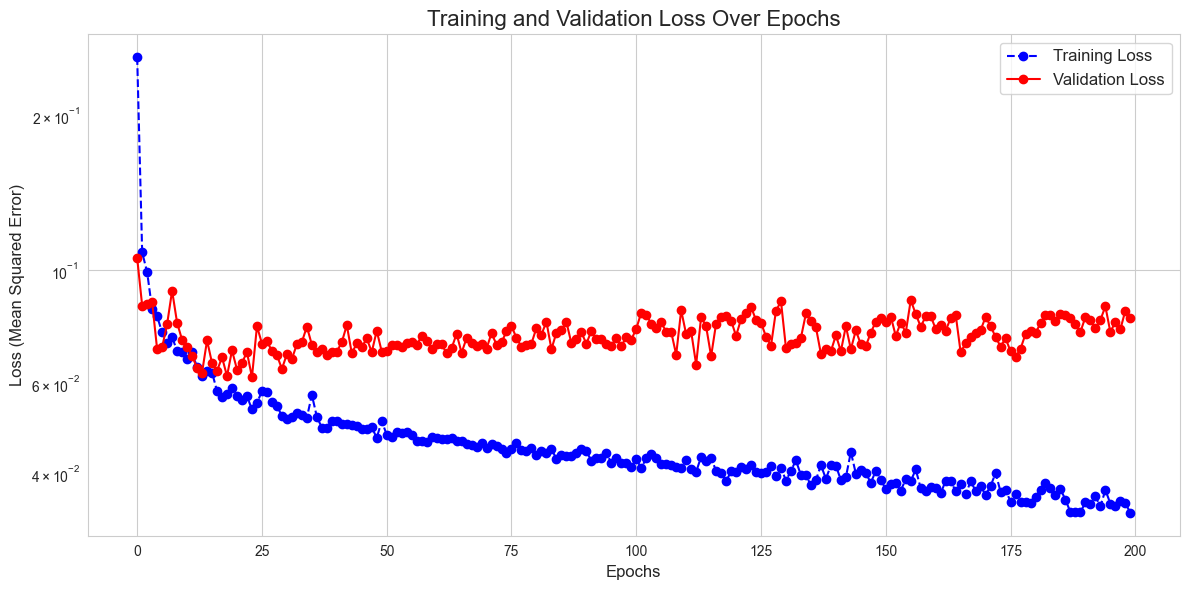

In [4]:
# (1번부터 6번까지의 데이터 준비 및 전처리 코드는 기존과 동일하게 실행합니다.)
# ... (코드 생략) ...
# X_train_deep, X_train_wide 등이 준비된 상태입니다.

import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================================
# 7. 과적합 유도를 위한 Wide & Deep 모델 설계 (모든 규제 제거)
# ===================================================================
print("\n🧠 과적합 유도를 위해 모든 규제를 제거한 모델을 설계합니다...")

# --- Deep Part (넓고, 규제 없음) ---
input_deep = Input(shape=(X_train_deep.shape[1],), name='Deep_Input')
hidden1 = Dense(512, activation='relu')(input_deep)
hidden2 = Dense(256, activation='relu')(hidden1)
output_deep = Dense(128, activation='relu')(hidden2)

# --- Wide Part (기존과 동일) ---
input_wide = Input(shape=(X_train_wide.shape[1],), name='Wide_Input')

# --- 결합 (Concatenate) ---
merged_layer = concatenate([output_deep, input_wide])
final_output = Dense(1)(merged_layer)

# 모델 생성
model = Model(inputs=[input_deep, input_wide], outputs=final_output)

# 모델 컴파일 (비교적 빠른 학습률 사용)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

print("\n✅ 모델 설계 완료! 이제 훈련을 시작합니다.")
model.summary()

# ===================================================================
# 8. 모델 훈련 (조기 종료 없이, 충분한 Epoch 실행)
# ===================================================================
print("\n🚀 과적합 관찰을 위해 조기 종료 없이 훈련을 진행합니다...")
history = model.fit(
    [X_train_deep, X_train_wide], y_train,
    epochs=200,  # 과적합을 관찰하기에 충분한 횟수
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
print("✅ 모델 훈련 완료")

# ===================================================================
# 9. 학습 곡선 시각화로 과적합 확인
# ===================================================================
print("\n📈 학습 곡선을 시각화하여 과적합을 확인합니다.")

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 훈련 손실(loss)과 검증 손실(val_loss)을 그립니다.
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o', linestyle='-')

plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend(fontsize=12)
plt.yscale('log') # 손실 값의 변화를 더 잘 보기 위해 y축을 로그 스케일로 변경
plt.tight_layout()
plt.savefig('overfitting_curve.png')

print("✅ 'overfitting_curve.png' 파일로 학습 곡선 그래프가 저장되었습니다.")
print("그래프에서 Training Loss는 계속 감소하지만 Validation Loss가 어느 시점부터 다시 상승하는지 확인해보세요.")

# ===================================================================
# 10. 최종 모델 평가 (참고용)
# ===================================================================
print("\n🏁 최종 성능 결과 (과적합 상태):")
y_pred = model.predict([X_test_deep, X_test_wide]).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 데이터 전처리 보강 완료

🤖 텍스트 임베딩을 생성합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]


📊 Wide & Deep 모델을 위한 데이터를 준비합니다...

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🧠 과적합 유도를 위해 모든 규제를 제거한 모델을 설계합니다...

✅ 모델 설계 완료! 이제 훈련을 시작합니다.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Deep_Input          │ (None, 1556)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │    797,184 │ Deep_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │    131,328 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     32,896 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Wide_Input          │ (None, 171)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 299)       │          0 │ dense_17[0][0],   │
│ (Concatenate)       │                   │            │ Wide_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │        300 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 961,708 (3.67 MB)

 Trainable params: 961,708 (3.67 MB)

 Non-trainable params: 0 (0.00 B)


🚀 과적합 관찰을 위해 조기 종료 없이 훈련을 진행합니다...
Epoch 1/200


E0000 00:00:1753420855.435102 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.4143 - val_loss: 0.1447
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1286 - val_loss: 0.1158
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1151 - val_loss: 0.1044
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0842 - val_loss: 0.0922
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0927 - val_loss: 0.0952
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0938 - val_loss: 0.0874
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0763 - val_loss: 0.0746
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0790 - val_loss: 0.0779
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0714 - val_loss: 0.0823
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0744 - val_loss: 0.0971
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0749 - val_loss: 0.0754
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

E0000 00:00:1753421007.708867 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² Score: 0.2946


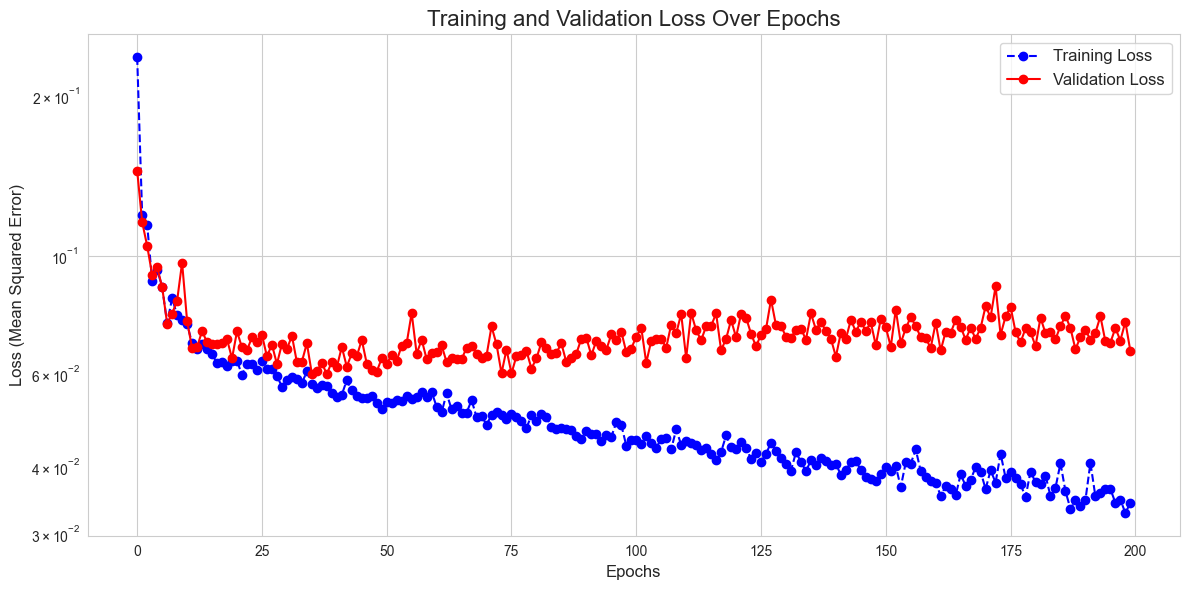

In [5]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학 (사용자 요청 반영)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# ⭐️ 요청사항 1: '일반분양', '특별분양'의 '-' 값을 0으로 변환
# pd.to_numeric의 errors='coerce' 옵션이 숫자가 아닌 값을 Na_N으로 만들고, .fillna(0)이 Na_N을 0으로 바꿉니다.
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)

# ⭐️ 요청사항 2: '기준년월'을 datetime으로 정확히 형변환
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')

# 나머지 특성 공학은 동일하게 진행
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')

df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']

infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 데이터 전처리 보강 완료")


# ===================================================================
# 4. 텍스트 임베딩 생성 (기존과 동일)
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)

# (이후 코드는 이전 과적합 유도 모델과 완전히 동일합니다.)

# ===================================================================
# 5. Wide & Deep 모델을 위한 데이터 준비
# ===================================================================
print("\n📊 Wide & Deep 모델을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

embedding_cols = [col for col in X.columns if 'embed' in col]
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in embedding_cols]
deep_cols = numerical_cols + embedding_cols
wide_cols = categorical_cols

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
deep_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
wide_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])
deep_preprocessor.fit(X_train[deep_cols])
wide_preprocessor.fit(X_train[wide_cols])
X_train_deep = deep_preprocessor.transform(X_train[deep_cols])
X_test_deep = deep_preprocessor.transform(X_test[deep_cols])
X_train_wide = wide_preprocessor.transform(X_train[wide_cols])
X_test_wide = wide_preprocessor.transform(X_test[wide_cols])
print("✅ 데이터 전처리 완료")

# ===================================================================
# 7. 과적합 유도를 위한 Wide & Deep 모델 설계 (모든 규제 제거)
# ===================================================================
print("\n🧠 과적합 유도를 위해 모든 규제를 제거한 모델을 설계합니다...")
input_deep = Input(shape=(X_train_deep.shape[1],), name='Deep_Input')
hidden1 = Dense(512, activation='relu')(input_deep)
hidden2 = Dense(256, activation='relu')(hidden1)
output_deep = Dense(128, activation='relu')(hidden2)
input_wide = Input(shape=(X_train_wide.shape[1],), name='Wide_Input')
merged_layer = concatenate([output_deep, input_wide])
final_output = Dense(1)(merged_layer)
model = Model(inputs=[input_deep, input_wide], outputs=final_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
print("\n✅ 모델 설계 완료! 이제 훈련을 시작합니다.")
model.summary()

# ===================================================================
# 8. 모델 훈련 (조기 종료 없이, 충분한 Epoch 실행)
# ===================================================================
print("\n🚀 과적합 관찰을 위해 조기 종료 없이 훈련을 진행합니다...")
history = model.fit(
    [X_train_deep, X_train_wide], y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
print("✅ 모델 훈련 완료")

# ===================================================================
# 9. 학습 곡선 시각화로 과적합 확인
# ===================================================================
print("\n📈 학습 곡선을 시각화하여 과적합을 확인합니다.")
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o', linestyle='-')
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend(fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.savefig('overfitting_curve_v2.png')
print("✅ 'overfitting_curve_v2.png' 파일로 학습 곡선 그래프가 저장되었습니다.")

# ===================================================================
# 10. 최종 모델 평가 (참고용)
# ===================================================================
print("\n🏁 최종 성능 결과 (과적합 상태):")
y_pred = model.predict([X_test_deep, X_test_wide]).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

In [7]:
# (1번부터 6번까지의 데이터 준비 및 전처리 코드는 이전과 동일하게 실행합니다.)
# ... (코드 생략) ...

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# ===================================================================
# 7. KerasTuner를 위한 Wide & Deep 모델 생성 함수
# ===================================================================

def build_model(hp):
    """하이퍼파라미터를 입력받아 최적화할 Wide & Deep 모델을 생성하는 함수"""
    # --- Deep Part ---
    input_deep = Input(shape=(X_train_deep.shape[1],), name='Deep_Input')

    # 하이퍼파라미터 탐색 공간 정의
    hp_units_1 = hp.Int('units_1', min_value=64, max_value=512, step=64)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_l2 = hp.Choice('l2', values=[0.01, 0.001, 0.0001, 0.0]) # 0.0은 규제 사용 안 함
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Layer 1
    hidden1 = Dense(
        units=hp_units_1,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)
    )(input_deep)
    drop1 = Dropout(hp_dropout)(hidden1)

    # Layer 2
    hidden2 = Dense(
        units=hp_units_2,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)
    )(drop1)
    output_deep = Dropout(hp_dropout)(hidden2)

    # --- Wide Part ---
    input_wide = Input(shape=(X_train_wide.shape[1],), name='Wide_Input')

    # --- 결합 (Concatenate) ---
    merged_layer = concatenate([output_deep, input_wide])
    final_output = Dense(1)(merged_layer)

    # 모델 생성 및 컴파일
    model = Model(inputs=[input_deep, input_wide], outputs=final_output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error'
    )
    return model

# ===================================================================
# 8. KerasTuner 실행
# ===================================================================
print("\n🤖 KerasTuner로 최적의 하이퍼파라미터 탐색을 시작합니다 (시간이 소요될 수 있습니다)...")

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # 20가지의 조합을 테스트
    executions_per_trial=2, # 안정성을 위해 각 조합을 2번씩 실행
    directory='kt_final_dir', # 이전과 다른 디렉토리 이름 사용
    project_name='wide_deep_final_tuning'
)

# 조기 종료 설정
stop_early = EarlyStopping(monitor='val_loss', patience=10)

# 튜너 탐색 시작
tuner.search(
    [X_train_deep, X_train_wide], y_train,
    epochs=100, # 최대 100까지 훈련하되, 조기종료가 최적점을 찾아줄 것
    validation_split=0.2,
    callbacks=[stop_early]
)

print("\n✅ 탐색 완료! 최적의 하이퍼파라미터는 다음과 같습니다:")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
- 첫 번째 은닉층 뉴런 수: {best_hps.get('units_1')}
- 두 번째 은닉층 뉴런 수: {best_hps.get('units_2')}
- 드롭아웃 비율: {best_hps.get('dropout'):.2f}
- L2 규제 강도: {best_hps.get('l2')}
- 학습률: {best_hps.get('learning_rate')}
""")

# ===================================================================
# 9. 최적 모델로 최종 평가
# ===================================================================
print("\n🔥 최적의 모델로 최종 성능을 평가합니다:")
best_model = tuner.get_best_models(num_models=1)[0]

y_pred = best_model.predict([X_test_deep, X_test_wide]).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Trial 20 Complete [00h 02m 42s]
val_loss: 0.33481211960315704

Best val_loss So Far: 0.05664678104221821
Total elapsed time: 00h 39m 12s

✅ 탐색 완료! 최적의 하이퍼파라미터는 다음과 같습니다:

- 첫 번째 은닉층 뉴런 수: 384
- 두 번째 은닉층 뉴런 수: 32
- 드롭아웃 비율: 0.10
- L2 규제 강도: 0.0
- 학습률: 0.001


🔥 최적의 모델로 최종 성능을 평가합니다:
 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

E0000 00:00:1753423609.848354 4870352 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

Mean Squared Error (MSE): 0.0665
Mean Absolute Error (MAE): 0.1850
R² Score: 0.2923


🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 데이터 전처리 완료

🤖 텍스트 임베딩을 생성합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

💡 LightGBM 모델을 사용하여 특성 중요도를 분석합니다...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82733
[LightGBM] [Info] Number of data points in the train set: 1771, number of used features: 1594
[LightGBM] [Info] Start training from score 0.819350
✅ LightGBM 모델 훈련 완료

📊 특성 중요도를 추출하고 시각화합니다.

[특성 중요도 Top 30]
                    feature  importance
18                      전용률         360
16                    평당분양가         325
2                       세대수         266
0                      일반분양         195
1                      특별분양         148
9                      총인구수         126
17                   인프라_점수         123
8                     Close          94
4                        환율          84
7                  KB매매가격지수          66
13                    월_sin  

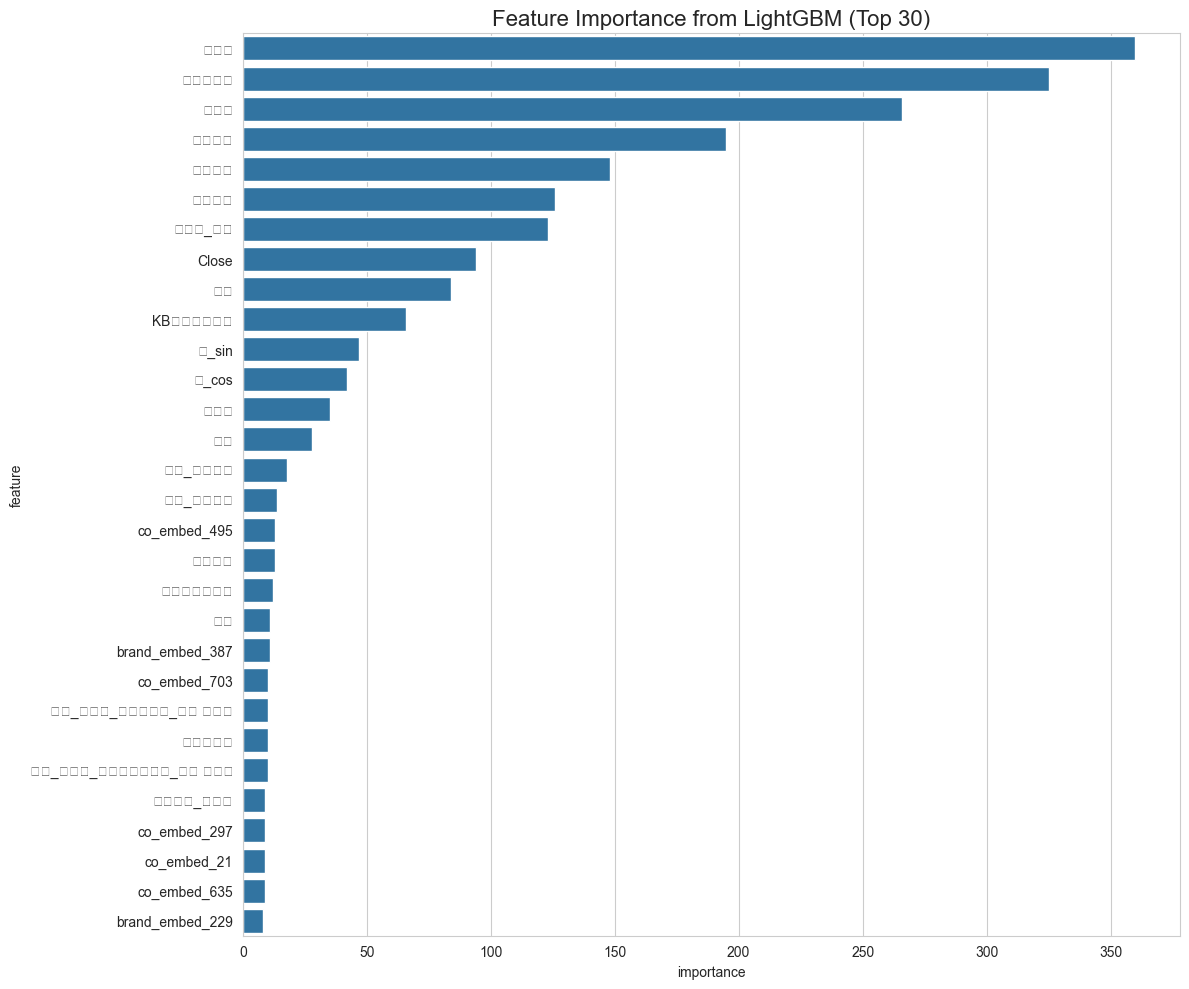

In [9]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    """주어진 텍스트 데이터에 대해 BERT 임베딩을 생성하는 함수"""
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    """아파트 이름에서 브랜드명을 추출하는 함수"""
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# '일반분양', '특별분양'의 '-' 값을 0으로 변환
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)

# '기준년월'을 datetime으로 형변환
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')

# 나머지 특성 공학
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 데이터 전처리 완료")

# ===================================================================
# 4. 텍스트 임베딩 생성
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

# 특성들을 수치형과 범주형으로 분리
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ],
    remainder='passthrough'
)
# 훈련 데이터에 전처리기 학습 및 변환 적용
X_train_processed = preprocessor.fit_transform(X_train)
# 테스트 데이터에는 학습된 전처리기로 변환만 적용
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 7. LightGBM 모델 훈련
# ===================================================================
print("\n💡 LightGBM 모델을 사용하여 특성 중요도를 분석합니다...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 모델 훈련 완료")

# ===================================================================
# 8. 특성 중요도 추출 및 시각화
# ===================================================================
print("\n📊 특성 중요도를 추출하고 시각화합니다.")

# 전처리된 후의 특성 이름들을 가져옵니다.
try:
    ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
    final_feature_names = numerical_cols + ohe_feature_names.tolist()
except Exception: # sparse_output=True일 경우 다른 방식 사용 대비
    ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out()
    final_feature_names = numerical_cols + ohe_feature_names.tolist()


# 특성 중요도를 데이터프레임으로 만듭니다.
feature_importances = pd.DataFrame(
    {'feature': final_feature_names, 'importance': lgbm.feature_importances_}
).sort_values('importance', ascending=False)

# 중요도 상위 30개만 출력
print("\n[특성 중요도 Top 30]")
print(feature_importances.head(30))

# 중요도 상위 30개 시각화
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30))
plt.title('Feature Importance from LightGBM (Top 30)', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\n✅ 'feature_importance.png' 파일로 특성 중요도 그래프가 저장되었습니다.")

# LightGBM 모델 자체의 성능도 확인해봅니다.
y_pred_lgbm = lgbm.predict(X_test_processed)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"\n참고: LightGBM 모델의 R² Score: {r2_lgbm:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

💡 LightGBM 모델(기본값)을 사용하여 특성 중요도를 분석합니다...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82733
[LightGBM] [Info] Number of data points in the train set: 1771, number of used features: 1594
[LightGBM] [Info] Start training from score 0.819350
✅ LightGBM 모델 훈련 완료

📊 특성 중요도를 추출하고 시각화합니다.
✅ 한글 폰트 'NanumGothic' 설정 완료

[특성 중요도 Top 30]
                    feature  importance
18                      전용률         360
16                    평당분양가         325
2                       세대수         266
0                      일반분양         195
1                      특별분양         148
9                      총인구수         126
17                   인프라_점수         123
8                     Close          94
4           

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon


✅ 'feature_importance_kor.png' 파일로 특성 중요도 그래프가 저장되었습니다.

참고: LightGBM 모델의 R² Score: 0.5222


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

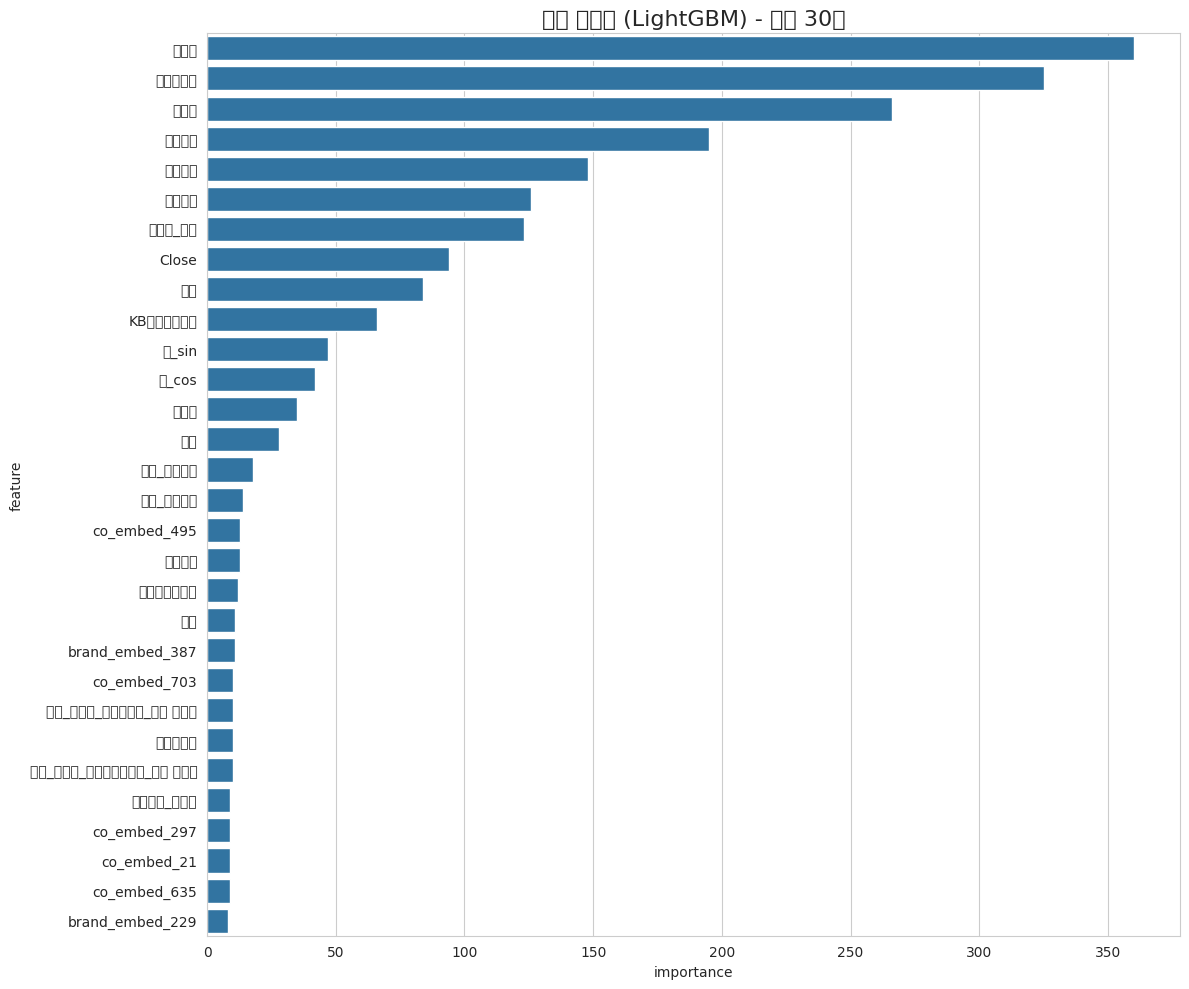

In [11]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

# ===================================================================
# 7. LightGBM 모델 훈련 (기본값)
# ===================================================================
print("\n💡 LightGBM 모델(기본값)을 사용하여 특성 중요도를 분석합니다...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 모델 훈련 완료")

# ===================================================================
# 8. 특성 중요도 추출 및 시각화 (한글 폰트 설정 추가)
# ===================================================================
print("\n📊 특성 중요도를 추출하고 시각화합니다.")

# ⭐️ 한글 폰트 설정 시작 ⭐️
# 나눔고딕 폰트가 설치되어 있는지 확인 후, 없으면 설치합니다.
font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    import requests
    url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"
    response = requests.get(url, allow_redirects=True)
    with open(font_path, 'wb') as f:
        f.write(response.content)

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
print(f"✅ 한글 폰트 '{font_name}' 설정 완료")
# ⭐️ 한글 폰트 설정 종료 ⭐️

# 전처리된 후의 특성 이름들을 가져옵니다.
ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
final_feature_names = numerical_cols + ohe_feature_names.tolist()

# 특성 중요도를 데이터프레임으로 만듭니다.
feature_importances = pd.DataFrame(
    {'feature': final_feature_names, 'importance': lgbm.feature_importances_}
).sort_values('importance', ascending=False)

# 중요도 상위 30개만 출력
print("\n[특성 중요도 Top 30]")
print(feature_importances.head(30))

# 중요도 상위 30개 시각화
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30))
plt.title('특성 중요도 (LightGBM) - 상위 30개', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance_kor.png')
print("\n✅ 'feature_importance_kor.png' 파일로 특성 중요도 그래프가 저장되었습니다.")

# LightGBM 모델 자체의 성능도 확인해봅니다.
y_pred_lgbm = lgbm.predict(X_test_processed)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"\n참고: LightGBM 모델의 R² Score: {r2_lgbm:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

💡 LightGBM 모델(기본값)을 사용하여 특성 중요도를 분석합니다...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82733
[LightGBM] [Info] Number of data points in the train set: 1771, number of used features: 1594
[LightGBM] [Info] Start training from score 0.819350
✅ LightGBM 모델 훈련 완료

📊 특성 중요도를 추출하고 시각화합니다.
✅ AppleGothic 폰트 설정 완료

[특성 중요도 Top 30]
                    feature  importance
18                      전용률         360
16                    평당분양가         325
2                       세대수         266
0                      일반분양         195
1                      특별분양         148
9                      총인구수         126
17                   인프라_점수         123
8                     Close          94
4                        환율          84
7                  KB매매가격지수          66
1

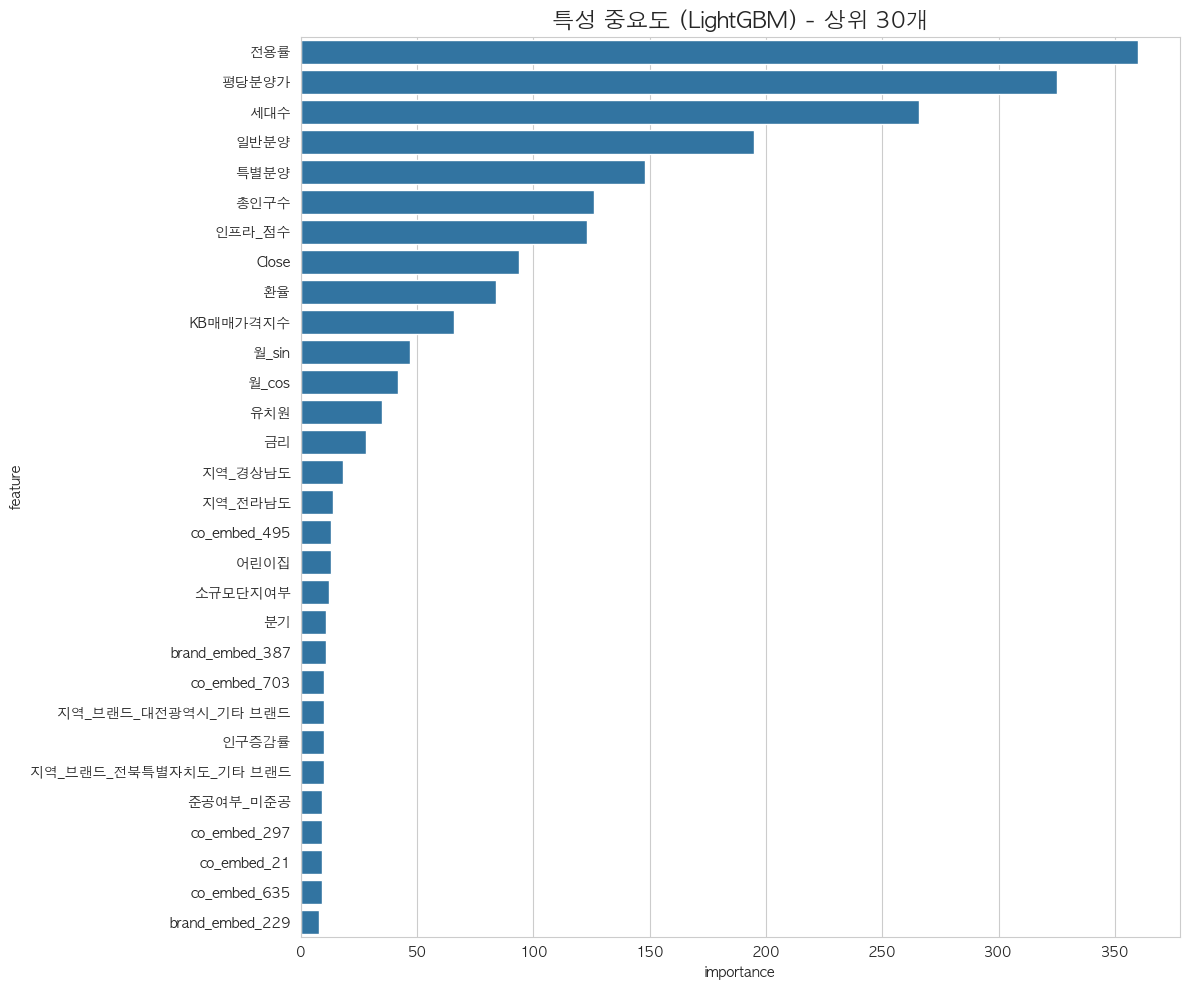

In [12]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import requests # 폰트 다운로드를 위해 추가

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

# ===================================================================
# 7. LightGBM 모델 훈련 (기본값)
# ===================================================================
print("\n💡 LightGBM 모델(기본값)을 사용하여 특성 중요도를 분석합니다...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 모델 훈련 완료")

# ===================================================================
# 8. 특성 중요도 추출 및 시각화 (AppleGothic 적용)
# ===================================================================
print("\n📊 특성 중요도를 추출하고 시각화합니다.")

# ⭐️ 한글 폰트 설정 시작 (AppleGothic 우선 시도) ⭐️
try:
    plt.rc('font', family='AppleGothic')
    print("✅ AppleGothic 폰트 설정 완료")
except:
    print("AppleGothic 폰트를 찾을 수 없어 나눔고딕을 설치합니다.")
    font_path = 'NanumGothic.ttf'
    if not os.path.exists(font_path):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"
        response = requests.get(url, allow_redirects=True)
        with open(font_path, 'wb') as f:
            f.write(response.content)
    font_name = fm.FontProperties(fname=font_path, size=50).get_name()
    plt.rc('font', family=font_name)
    print("✅ 나눔고딕 폰트 설정 완료")

plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
# ⭐️ 한글 폰트 설정 종료 ⭐️

# 전처리된 후의 특성 이름들을 가져옵니다.
ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
final_feature_names = numerical_cols + ohe_feature_names.tolist()

# 특성 중요도를 데이터프레임으로 만듭니다.
feature_importances = pd.DataFrame(
    {'feature': final_feature_names, 'importance': lgbm.feature_importances_}
).sort_values('importance', ascending=False)

# 중요도 상위 30개만 출력
print("\n[특성 중요도 Top 30]")
print(feature_importances.head(30))

# 중요도 상위 30개 시각화
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30))
plt.title('특성 중요도 (LightGBM) - 상위 30개', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance_kor.png')
print("\n✅ 'feature_importance_kor.png' 파일로 특성 중요도 그래프가 저장되었습니다.")

# LightGBM 모델 자체의 성능도 확인해봅니다.
y_pred_lgbm = lgbm.predict(X_test_processed)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"\n참고: LightGBM 모델의 R² Score: {r2_lgbm:.4f}")


🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 특성 공학 완료 (상호작용 특성 추가)

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

💡 LightGBM 모델(기본값)을 사용하여 특성 중요도를 분석합니다...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83243
[LightGBM] [Info] Number of data points in the train set: 1771, number of used features: 1596
[LightGBM] [Info] Start training from score 0.819350
✅ LightGBM 모델 훈련 완료

📊 특성 중요도를 추출하고 시각화합니다.

[특성 중요도 Top 30]
                 feature  importance
18                   전용률         303
21               단지인프라총점         223
16                 평당분양가         210
0                   일반분양         174
2                    세대수         170
20                시세비분양가         144
9                   총인구수         142
1                   특별분양         141
17                인프라_점수         117
4                     환율          82
8                  Close          74
7               KB매매

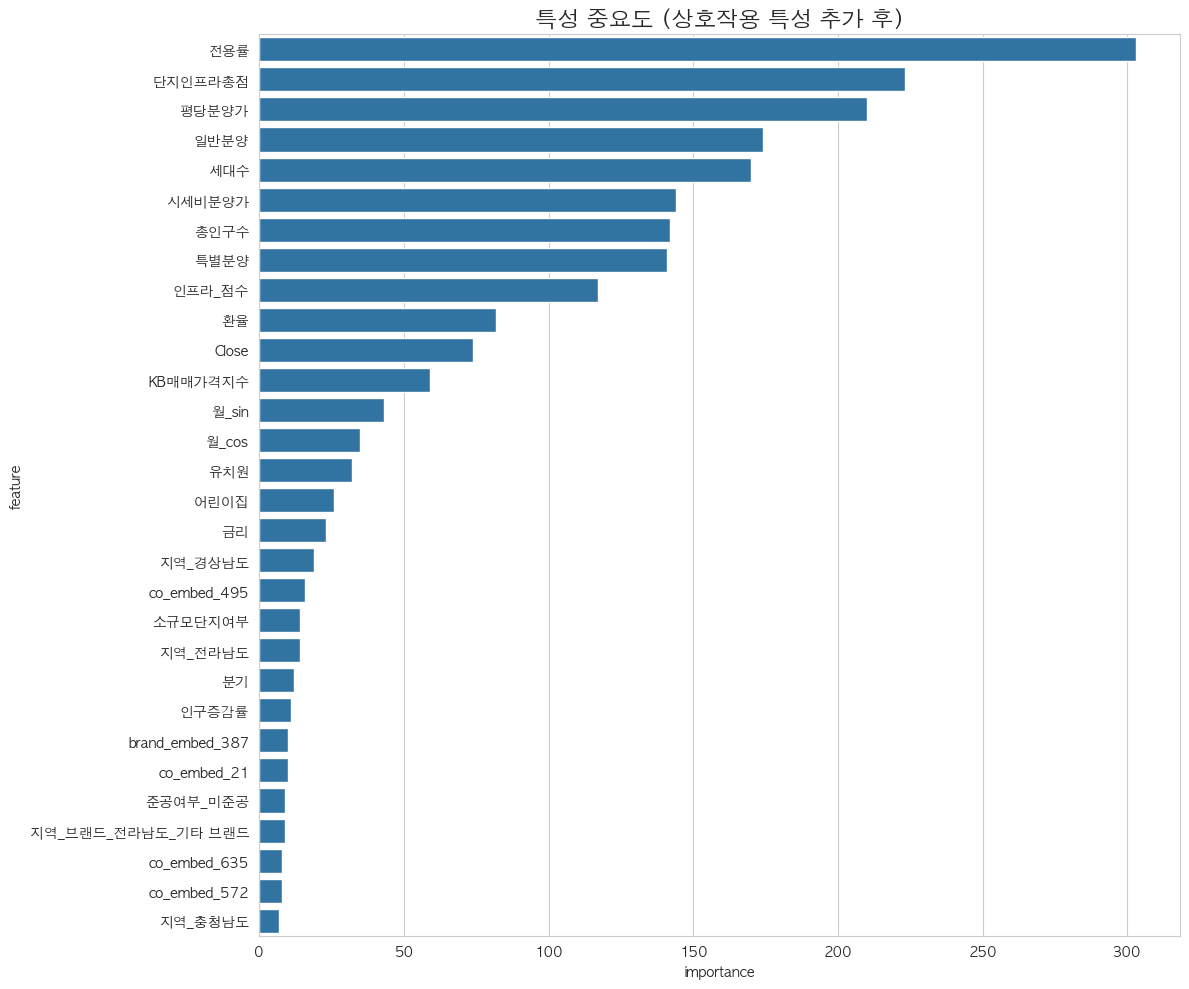

In [13]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import requests

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학 (⭐️ 상호작용 특성 추가)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)

# ⭐️ 새로운 상호작용 특성 추가 ⭐️
df['시세비분양가'] = df['평당분양가'] / df['KB매매가격지수']
df['단지인프라총점'] = df['세대수'] * df['인프라_점수']
# 무한대 값, NaN 값 처리
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True) # 간단하게 0으로 채우기
print("✅ 특성 공학 완료 (상호작용 특성 추가)")


# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

# ===================================================================
# 7. LightGBM 모델 훈련 (기본값)
# ===================================================================
print("\n💡 LightGBM 모델(기본값)을 사용하여 특성 중요도를 분석합니다...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 모델 훈련 완료")

# ===================================================================
# 8. 특성 중요도 추출 및 시각화
# ===================================================================
print("\n📊 특성 중요도를 추출하고 시각화합니다.")

# 한글 폰트 설정
try:
    plt.rc('font', family='AppleGothic')
except:
    font_path = 'NanumGothic.ttf'
    if not os.path.exists(font_path):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"
        response = requests.get(url, allow_redirects=True)
        with open(font_path, 'wb') as f:
            f.write(response.content)
    font_name = fm.FontProperties(fname=font_path, size=50).get_name()
    plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 전처리된 후의 특성 이름들을 가져옵니다.
ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
final_feature_names = numerical_cols + ohe_feature_names.tolist()

# 특성 중요도를 데이터프레임으로 만듭니다.
feature_importances = pd.DataFrame(
    {'feature': final_feature_names, 'importance': lgbm.feature_importances_}
).sort_values('importance', ascending=False)

# 중요도 상위 30개만 출력
print("\n[특성 중요도 Top 30]")
print(feature_importances.head(30))

# 중요도 상위 30개 시각화
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30))
plt.title('특성 중요도 (상호작용 특성 추가 후)', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance_interaction.png')
print("\n✅ 'feature_importance_interaction.png' 파일로 특성 중요도 그래프가 저장되었습니다.")

# 최종 성능 확인
y_pred_lgbm = lgbm.predict(X_test_processed)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"\n최종 R² Score (상호작용 특성 추가): {r2_lgbm:.4f}")

In [14]:
# ===================================================================
# 1. 라이브러리 임포트 (앙상블 모델 추가)
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    # ... (브랜드 리스트는 기존과 동일하게 유지) ...
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학 (가장 성능이 좋았던 버전으로 복구)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 7. 스태킹 앙상블 모델 정의 및 훈련
# ===================================================================
print("\n🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...")

# 1단계 기본 모델(전문가) 정의
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]

# 2단계 메타 모델(위원장)과 스태킹 모델 정의
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(), # 여러 규제 값을 테스트하여 최적의 선형 모델을 찾음
    cv=5, # 교차 검증 횟수
    n_jobs=-1
)

# 스태킹 모델 훈련
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")


# ===================================================================
# 8. 최종 성능 평가
# ===================================================================
print("\n🏁 스태킹 앙상블 모델의 최종 성능을 평가합니다:")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\n🎯 최종 R² Score: {r2_stack:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47366
[LightGBM] [Info] Number of data points in the train set: 1771, number of used features: 821
[LightGBM] [Info] Start training from score 0.819350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44081
[LightGBM] [Info] Number of data points in the train set: 1417, number of used features: 821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44573
[LightGBM] [Info] Auto-choosing col-wise m

In [15]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    # ... (브랜드 리스트는 기존과 동일하게 유지) ...
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학 (⭐️ 세대수 필터링 추가)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# ⭐️ 사용자 아이디어 적용: 세대수가 3 이하인 데이터 제외
original_rows = len(df)
df = df[df['세대수'] > 3].reset_index(drop=True)
print(f"✅ 세대수 3 이하 데이터 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")


# '일반분양', '특별분양'의 '-' 값을 0으로 변환
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 7. 스태킹 앙상블 모델 정의 및 훈련
# ===================================================================
print("\n🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...")

# 1단계 기본 모델(전문가) 정의
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]

# 2단계 메타 모델(위원장)과 스태킹 모델 정의
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

# 스태킹 모델 훈련
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")


# ===================================================================
# 8. 최종 성능 평가
# ===================================================================
print("\n🏁 스태킹 앙상블 모델의 최종 성능을 평가합니다:")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\n🎯 최종 R² Score: {r2_stack:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 세대수 3 이하 데이터 제거 완료: 2214개 -> 1982개 (232개 행 제거)
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possibl

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46443
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 821
[LightGBM] [Info] Start training from score 0.828924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40972
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 821
[LightGBM] [I

In [16]:
# ===================================================================
# 1. 라이브러리 임포트 (cross_val_score 추가)
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    # ... (브랜드 리스트는 기존과 동일하게 유지) ...
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# 세대수가 3 이하인 데이터 제외
original_rows = len(df)
df = df[df['세대수'] > 3].reset_index(drop=True)
print(f"✅ 세대수 3 이하 데이터 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")


# '일반분양', '특별분양'의 '-' 값을 0으로 변환
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 및 파이프라인 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

# 전처리 파이프라인 정의
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])

# 스태킹 앙상블 모델 정의
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5, # 스태킹 모델 내부의 교차 검증
    n_jobs=-1
)

# 전처리기와 모델을 하나의 파이프라인으로 결합
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', stacking_model)])

print("✅ 전체 파이프라인 준비 완료")

# ===================================================================
# 6. 교차 검증 실행 및 결과 확인
# ===================================================================
print("\n🔄 5-겹 교차 검증을 실행합니다 (시간이 소요될 수 있습니다)...")

# 교차 검증 폴드 설정
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 점수 계산
scores = cross_val_score(full_pipeline, X, y, cv=kfold, scoring='r2')

print("✅ 교차 검증 완료!")
print("\n📋 교차 검증 결과 (R² Score):")
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {score:.4f}")

print(f"\n📈 평균 R² Score: {np.mean(scores):.4f}")
print(f"📊 R² Score 표준편차: {np.std(scores):.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 세대수 3 이하 데이터 제거 완료: 2214개 -> 1982개 (232개 행 제거)
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 전체 파이프라인 준비 완료

🔄 5-겹 교차 검증을 실행합니다 (시간이 소요될 수 있습니다)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46443
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 821
[LightGBM] [Info] Start training from score 0.828924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 820
[LightGBM] [Info] Total Bins 39930
[LightGB

In [17]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    # ... (브랜드 리스트는 기존과 동일하게 유지) ...
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학 (⭐️ 데이터 누수 방지 추가)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# ⭐️ 데이터 누수 방지: 타겟 변수에 결측치가 있는 행을 제거
original_rows = len(df)
df.dropna(subset=['분양률'], inplace=True)
print(f"✅ '분양률' 결측치 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")


# 세대수가 3 이하인 데이터 제외
original_rows = len(df)
df = df[df['세대수'] > 3].reset_index(drop=True)
print(f"✅ 세대수 3 이하 데이터 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")


# '일반분양', '특별분양'의 '-' 값을 0으로 변환
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
# (이후 특성 공학 코드는 기존과 동일)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")


# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 및 파이프라인 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]

# 전처리 파이프라인 정의
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])

# 스태킹 앙상블 모델 정의
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

# 전처리기와 모델을 하나의 파이프라인으로 결합
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', stacking_model)])
print("✅ 전체 파이프라인 준비 완료")

# ===================================================================
# 6. 교차 검증 실행 및 결과 확인
# ===================================================================
print("\n🔄 5-겹 교차 검증을 실행합니다 (시간이 소요될 수 있습니다)...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(full_pipeline, X, y, cv=kfold, scoring='r2')

print("✅ 교차 검증 완료!")
print("\n📋 교차 검증 결과 (R² Score):")
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {score:.4f}")

print(f"\n📈 평균 R² Score: {np.mean(scores):.4f}")
print(f"📊 R² Score 표준편차: {np.std(scores):.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ '분양률' 결측치 제거 완료: 2214개 -> 2214개 (0개 행 제거)
✅ 세대수 3 이하 데이터 제거 완료: 2214개 -> 1982개 (232개 행 제거)
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 전체 파이프라인 준비 완료

🔄 5-겹 교차 검증을 실행합니다 (시간이 소요될 수 있습니다)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46443
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 821
[LightGBM] [Info] Start training from score 0.828924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39930
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 819
[LightGBM] [Info] Start training from score 0.833092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016140 seconds.
You can set `force_col_wise=true` to remove the

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41284
[LightGBM] [Info] Total Bins 42383
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 820
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35827
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [18]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학 (⭐️ 데이터 누수 방지 추가)
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# ⭐️ 데이터 누수 방지: 타겟 변수에 결측치가 있는 행을 먼저 제거
original_rows = len(df)
df.dropna(subset=['분양률'], inplace=True)
print(f"✅ '분양률' 결측치 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")

# 세대수가 3 이하인 데이터 제외
original_rows = len(df)
df = df[df['세대수'] > 3].reset_index(drop=True)
print(f"✅ 세대수 3 이하 데이터 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")


# '일반분양', '특별분양'의 '-' 값을 0으로 변환
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ 데이터 준비 완료")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 7. 스태킹 앙상블 모델 정의 및 훈련
# ===================================================================
print("\n🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...")

# 1단계 기본 모델(전문가) 정의
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]

# 2단계 메타 모델(위원장)과 스태킹 모델 정의
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5, # 스태킹 모델 내부의 교차 검증은 그대로 유지하는 것이 안정적입니다.
    n_jobs=-1
)

# 스태킹 모델 훈련
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")


# ===================================================================
# 8. 최종 성능 평가
# ===================================================================
print("\n🏁 스태킹 앙상블 모델의 최종 성능을 평가합니다:")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\n🎯 최종 R² Score: {r2_stack:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ '분양률' 결측치 제거 완료: 2214개 -> 2214개 (0개 행 제거)
✅ 세대수 3 이하 데이터 제거 완료: 2214개 -> 1982개 (232개 행 제거)
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81803
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 1591
[LightGBM] [Info] Start training from score 0.828924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74944
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 1587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 0.827266
[LightGBM] [Info] 

In [19]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# 타겟 변수 결측치 제거
original_rows = len(df)
df.dropna(subset=['분양률'], inplace=True)
print(f"✅ '분양률' 결측치 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")

# 세대수가 3 이하인 데이터 제외
original_rows = len(df)
df = df[df['세대수'] > 3].reset_index(drop=True)
print(f"✅ 세대수 3 이하 데이터 제거 완료: {original_rows}개 -> {len(df)}개 ({original_rows - len(df)}개 행 제거)")


# '일반분양', '특별분양'의 '-' 값을 0으로 변환
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비 (⭐️ random_state 변경)
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# ⭐️ random_state를 42에서 1004로 변경
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)
print("✅ 데이터 준비 완료 (random_state=1004)")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 7. 스태킹 앙상블 모델 정의 및 훈련
# ===================================================================
print("\n🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...")

# 1단계 기본 모델(전문가) 정의
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]

# 2단계 메타 모델(위원장)과 스태킹 모델 정의
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

# 스태킹 모델 훈련
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")


# ===================================================================
# 8. 최종 성능 평가
# ===================================================================
print("\n🏁 스태킹 앙상블 모델의 최종 성능을 평가합니다:")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\n🎯 최종 R² Score: {r2_stack:.4f}")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ '분양률' 결측치 제거 완료: 2214개 -> 2214개 (0개 행 제거)
✅ 세대수 3 이하 데이터 제거 완료: 2214개 -> 1982개 (232개 행 제거)
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료 (random_state=1004)

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🔥 스태킹 앙상블 모델 훈련을 시작합니다 (시간이 소요될 수 있습니다)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got fork

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83970
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 1589
[LightGBM] [Info] Start training from score 0.826072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77040
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 1586
[LightGBM] [Info] Start training from score 0.829997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto

In [20]:
# ===================================================================
# 1. 라이브러리 임포트 (pickle 추가)
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import pickle # 모델 저장을 위해 추가

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")
df.dropna(subset=['분양률'], inplace=True)
df = df[df['세대수'] > 3].reset_index(drop=True)
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)
print("✅ 데이터 준비 완료 (random_state=1004)")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# ===================================================================
# 7. 스태킹 앙상블 모델 정의 및 훈련
# ===================================================================
print("\n🔥 스태킹 앙상블 모델 훈련을 시작합니다...")

estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")


# ===================================================================
# 8. 최종 성능 평가
# ===================================================================
print("\n🏁 스태킹 앙상블 모델의 최종 성능을 평가합니다:")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\n🎯 최종 R² Score: {r2_stack:.4f}")


# ===================================================================
# 9. ⭐️ 모델 및 전처리기 저장
# ===================================================================
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("\n✅ 모델과 전처리기가 'stacking_model.pkl', 'preprocessor.pkl' 파일로 저장되었습니다.")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료 (random_state=1004)

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🔥 스태킹 앙상블 모델 훈련을 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83970
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 1589
[LightGBM] [Info] Start training from score 0.826072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75263
[LightG

In [21]:
import pandas as pd

try:
    # CSV 파일 경로를 실제 파일 위치에 맞게 수정해주세요.
    df = pd.read_csv("final_data.csv") 
    
    infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
    
    print("===== 인프라 칼럼 목록 =====")
    print(infra_cols)
    print("==========================")

except FileNotFoundError:
    print("오류: 'final_data.csv' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")

===== 인프라 칼럼 목록 =====
['대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내', '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내']


In [22]:
# ===================================================================
# 1. 라이브러리 임포트
# ===================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import pickle

warnings.filterwarnings('ignore')

# ===================================================================
# 2. 함수 및 리스트 정의
# ===================================================================
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# ===================================================================
# 3. 데이터 로드 및 특성 공학
# ===================================================================
print("🚚 데이터를 로드하고 특성 공학을 적용합니다...")
df = pd.read_csv("final_data.csv")

# ===================================================================
# ✅✅✅ 핵심 수정 부분 1: 제외할 피처 목록 수정 ✅✅✅
# ===================================================================
# 금리, 환율은 이제 제외하지 않음
features_to_drop = [
    '준공여부', '어린이집', '유치원',
    'KB매매가격지수', 'Close', '총인구수', '인구증감률'
]
original_columns = df.columns.tolist()
df = df.drop(columns=features_to_drop, errors='ignore')
dropped_count = len(original_columns) - len(df.columns)
print(f"✅ 사용 편의성을 위해 {dropped_count}개의 피처를 제외했습니다.")
# ===================================================================

df.dropna(subset=['분양률'], inplace=True)
df = df[df['세대수'] > 3].reset_index(drop=True)
# (이하 특성 공학 과정은 동일)
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")

# ===================================================================
# 4. BERT 임베딩 생성 및 포함
# ===================================================================
print(f"\n🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")

# ===================================================================
# 5. 모델링을 위한 데이터 준비
# ===================================================================
print("\n📊 모델링을 위한 데이터를 준비합니다...")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)
print(f"✅ 데이터 준비 완료 (Train: {len(X_train)}, Test: {len(X_test)})")

# ===================================================================
# 6. 데이터 전처리 파이프라인
# ===================================================================
print("\n🔄 데이터 전처리를 시작합니다...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

# ===================================================================
# ✅✅✅ 핵심 수정 부분 2: 최종 학습 피처 목록 확인 ✅✅✅
# ===================================================================
try:
    # 전처리 후 생성된 최종 컬럼 이름들을 가져옵니다.
    final_feature_names = preprocessor.get_feature_names_out()
    print("\n" + "="*50)
    print("✅ 최종 학습에 사용되는 컬럼 목록입니다:")
    print(f"  (총 {len(final_feature_names)}개)")
    print(final_feature_names)
    print("="*50 + "\n")
except Exception as e:
    print(f"최종 컬럼 목록을 가져오는 데 실패했습니다: {e}")
# ===================================================================


# ===================================================================
# 7. 스태킹 앙상블 모델 정의 및 훈련
# ===================================================================
print("\n🔥 스태킹 앙상블 모델 훈련을 시작합니다...")
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")


# ===================================================================
# 8. 최종 성능 평가
# ===================================================================
print("\n🏁 스태킹 앙상블 모델의 최종 성능을 평가합니다:")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)

print("\n" + "="*50)
print(f"🎯 최종 모델의 R² Score: {r2_stack:.4f}")
print("="*50 + "\n")


# ===================================================================
# 9. ⭐️ 새 모델 및 전처리기 저장
# ===================================================================
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("✅ 최종 모델과 전처리기가 'stacking_model.pkl', 'preprocessor.pkl' 파일로 덮어쓰기 저장되었습니다.")

🚚 데이터를 로드하고 특성 공학을 적용합니다...
✅ 사용 편의성을 위해 7개의 피처를 제외했습니다.
✅ 특성 공학 완료

🤖 텍스트 임베딩을 생성하여 데이터에 포함합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료

📊 모델링을 위한 데이터를 준비합니다...
✅ 데이터 준비 완료 (Train: 1585, Test: 397)

🔄 데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

✅ 최종 학습에 사용되는 컬럼 목록입니다:
  (총 1717개)
['num__일반분양' 'num__특별분양' 'num__세대수' ... 'cat__지역_브랜드_충청북도_푸르지오'
 'cat__지역_브랜드_충청북도_한라비발디' 'cat__지역_브랜드_충청북도_힐스테이트']


🔥 스태킹 앙상블 모델 훈련을 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment varia

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83713
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 1580
[LightGBM] [Info] Start training from score 0.826072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78398
[LightGBM] [Info] Total Bins 77847
[

In [23]:
import pickle

# 확인할 파일 경로
PREPROCESSOR_PATH = 'preprocessor.pkl'
MODEL_PATH = 'stacking_model.pkl'

print(f"'{PREPROCESSOR_PATH}'와 '{MODEL_PATH}' 파일을 로드하여 필요한 입력 피처를 확인합니다.\n")

try:
    # 전처리기(preprocessor) 로드
    with open(PREPROCESSOR_PATH, 'rb') as f:
        preprocessor = pickle.load(f)
    print(f"✅ '{PREPROCESSOR_PATH}' 파일 로드 성공!")

    # 모델(stacking_model) 로드 (정상적으로 로드되는지 확인용)
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)
    print(f"✅ '{MODEL_PATH}' 파일 로드 성공!")

    # 전처리기가 학습 시 사용했던 원본 피처(컬럼) 이름들을 가져옴
    required_inputs = preprocessor.feature_names_in_

    print("\n" + "="*60)
    print("✅ 모델이 예측을 위해 필요로 하는 최종 입력 컬럼 목록입니다.")
    print(f"  (총 {len(required_inputs)}개)")
    print("="*60)

    # 목록을 보기 쉽게 번호를 붙여 출력
    for i, col_name in enumerate(required_inputs):
        print(f"{i+1:2d}. {col_name}")

    print("\n" + "="*60)
    print("이 목록이 현재 UI의 입력 항목과 일치하는지 확인하시면 됩니다.")
    print("="*60)


except FileNotFoundError:
    print(f"❌ 오류: '{PREPROCESSOR_PATH}' 또는 '{MODEL_PATH}' 파일을 찾을 수 없습니다.")
    print("모델 학습 스크립트를 실행하여 파일을 먼저 생성해주세요.")
except Exception as e:
    print(f"❌ 파일을 로드하거나 분석하는 중 오류가 발생했습니다: {e}")

'preprocessor.pkl'와 'stacking_model.pkl' 파일을 로드하여 필요한 입력 피처를 확인합니다.

✅ 'preprocessor.pkl' 파일 로드 성공!
✅ 'stacking_model.pkl' 파일 로드 성공!

✅ 모델이 예측을 위해 필요로 하는 최종 입력 컬럼 목록입니다.
  (총 1553개)
 1. 지역
 2. 일반분양
 3. 특별분양
 4. 세대수
 5. 금리
 6. 환율
 7. 소규모단지여부
 8. 년
 9. 월_sin
10. 월_cos
11. 분기
12. 건설사_등급
13. 지역_브랜드
14. 평당분양가
15. 인프라_점수
16. 전용률
17. 특별분양유무
18. brand_embed_0
19. brand_embed_1
20. brand_embed_2
21. brand_embed_3
22. brand_embed_4
23. brand_embed_5
24. brand_embed_6
25. brand_embed_7
26. brand_embed_8
27. brand_embed_9
28. brand_embed_10
29. brand_embed_11
30. brand_embed_12
31. brand_embed_13
32. brand_embed_14
33. brand_embed_15
34. brand_embed_16
35. brand_embed_17
36. brand_embed_18
37. brand_embed_19
38. brand_embed_20
39. brand_embed_21
40. brand_embed_22
41. brand_embed_23
42. brand_embed_24
43. brand_embed_25
44. brand_embed_26
45. brand_embed_27
46. brand_embed_28
47. brand_embed_29
48. brand_embed_30
49. brand_embed_31
50. brand_embed_32
51. brand_embed_33
52. brand_embed_34
53. brand

In [25]:
# final_retrain_script.py

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import pickle

warnings.filterwarnings('ignore')

# 헬퍼 함수 (기존과 동일)
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad(): outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy(); embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name: return brand
    return '기타 브랜드'

# 데이터 로드
print("🚚 데이터를 로드합니다...")
df = pd.read_csv("final_data.csv")

# ✅✅✅ 최종 피처 제외 목록 ('Close' 추가) ✅✅✅
features_to_drop = [
    '준공여부', '어린이집', '유치원', 'KB매매가격지수', 
    'Close',  # 코스피 종가 제외
    '총인구수', '인구증감률'
]
print(f"다음 피처들을 제외합니다: {features_to_drop}")
df = df.drop(columns=features_to_drop, errors='ignore')

# (이하 모든 과정은 이전과 동일합니다)
df.dropna(subset=['분양률'], inplace=True)
df = df[df['세대수'] > 3].reset_index(drop=True)
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
with open('brand_priority_list.txt', 'r', encoding='utf-8') as f:
    brand_priority_list = [line.strip() for line in f.readlines()]
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = (df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)).replace([np.inf, -np.inf], 0).fillna(0)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = ((df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100).replace([np.inf, -np.inf], 0).fillna(0)
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)
print(f"✅ 데이터 준비 완료 (Train: {len(X_train)}, Test: {len(X_test)})")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")
estimators = [('lgbm', lgb.LGBMRegressor(random_state=42)), ('xgb', xgb.XGBRegressor(random_state=42)), ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(), cv=5, n_jobs=-1)
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)
print("\n" + "="*50); print(f"🎯 최종 모델의 R² Score: {r2_stack:.4f}"); print("="*50 + "\n")
with open('stacking_model.pkl', 'wb') as f: pickle.dump(stacking_model, f)
with open('preprocessor.pkl', 'wb') as f: pickle.dump(preprocessor, f)
print("✅ 최종 모델과 전처리기가 'stacking_model.pkl', 'preprocessor.pkl' 파일로 덮어쓰기 저장되었습니다.")

🚚 데이터를 로드합니다...
다음 피처들을 제외합니다: ['준공여부', '어린이집', '유치원', 'KB매매가격지수', 'Close', '총인구수', '인구증감률']
✅ 특성 공학 완료


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료
✅ 데이터 준비 완료 (Train: 1585, Test: 397)
✅ 데이터 전처리 완료


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possibl

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83713
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 1580
[LightGBM] [Info] Start training from score 0.826072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78862
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 1576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77847
[Light

In [26]:
# final_simple_model_retrain.py

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import warnings
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import pickle

warnings.filterwarnings('ignore')

# 헬퍼 함수 (기존과 동일)
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad(): outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy(); embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name: return brand
    return '기타 브랜드'

# 데이터 로드
print("🚚 데이터를 로드합니다...")
df = pd.read_csv("final_data.csv")

# ✅✅✅ 최종 피처 제외 목록 ('금리', '환율' 추가) ✅✅✅
features_to_drop = [
    '준공여부', '어린이집', '유치원', 'KB매매가격지수', 
    'Close', '총인구수', '인구증감률',
    '금리', '환율'  # 금리, 환율 제외
]
print(f"다음 피처들을 제외합니다: {features_to_drop}")
df = df.drop(columns=features_to_drop, errors='ignore')

# (이하 모든 과정은 이전과 동일합니다)
df.dropna(subset=['분양률'], inplace=True)
df = df[df['세대수'] > 3].reset_index(drop=True)
df['일반분양'] = pd.to_numeric(df['일반분양'], errors='coerce').fillna(0)
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['기준년월', '미분양수', '주변시세 평균', '월'], inplace=True, errors='ignore')
with open('brand_priority_list.txt', 'r', encoding='utf-8') as f:
    brand_priority_list = [line.strip() for line in f.readlines()]
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = (df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)).replace([np.inf, -np.inf], 0).fillna(0)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = ((df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100).replace([np.inf, -np.inf], 0).fillna(0)
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
print("✅ 특성 공학 완료")
MODEL_NAME = "kykim/bert-kor-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)
print("✅ 임베딩 생성 및 결합 완료")
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)
print(f"✅ 데이터 준비 완료 (Train: {len(X_train)}, Test: {len(X_test)})")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")
estimators = [('lgbm', lgb.LGBMRegressor(random_state=42)), ('xgb', xgb.XGBRegressor(random_state=42)), ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(), cv=5, n_jobs=-1)
stacking_model.fit(X_train_processed, y_train)
print("✅ 스태킹 모델 훈련 완료")
y_pred_stack = stacking_model.predict(X_test_processed)
r2_stack = r2_score(y_test, y_pred_stack)
print("\n" + "="*50); print(f"🎯 최종 모델의 R² Score: {r2_stack:.4f}"); print("="*50 + "\n")
with open('stacking_model.pkl', 'wb') as f: pickle.dump(stacking_model, f)
with open('preprocessor.pkl', 'wb') as f: pickle.dump(preprocessor, f)
print("✅ 최종 모델과 전처리기가 'stacking_model.pkl', 'preprocessor.pkl' 파일로 덮어쓰기 저장되었습니다.")

🚚 데이터를 로드합니다...
다음 피처들을 제외합니다: ['준공여부', '어린이집', '유치원', 'KB매매가격지수', 'Close', '총인구수', '인구증감률', '금리', '환율']
✅ 특성 공학 완료


텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1982 [00:00<?, ?it/s]

✅ 임베딩 생성 및 결합 완료
✅ 데이터 준비 완료 (Train: 1585, Test: 397)
✅ 데이터 전처리 완료


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
To disable this warning, you can either:
	- Avoid using `

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83660
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 1578
[LightGBM] [Info] Start training from score 0.826072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if 